In [185]:
# from google.colab import drive
# drive.mount('/content/drive')

In [186]:
!pip install scipy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [187]:
!pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [188]:
!pip install spacy

You should consider upgrading via the 'pip install --upgrade pip' command.


## Import packages and data

In [189]:
import filter_method
import outlier

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
from scipy import stats 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [191]:
path = ""

In [192]:
X_train = pd.read_pickle("X_train_20000.pkl")
X_test = pd.read_pickle("X_test_20000.pkl")
y_train = pd.read_pickle("y_train_20000.pkl")
y_test = pd.read_pickle("y_test_20000.pkl")

In [193]:
# check same length of samples and labels
# train
assert X_train.shape[0] == y_train.shape[0]
# test
assert X_test.shape[0] == y_test.shape[0]

# check same features
assert X_train.shape[1] == X_test.shape[1]

## Delete irrelevant features and outliers.

### Delete text features

In [194]:
del X_train['joke_x']
del X_train['joke_tokenized']
del X_train['joke_text_processed']
del X_train['joke_processed_tokenized']
del X_train['joke_processed_tokenized_stemmed']
del X_train['joke_processed_tokenized_stemmed_str']
# del X_train['joke_embbedings']
del X_test['joke_x']
del X_test['joke_tokenized']
del X_test['joke_text_processed']
del X_test['joke_processed_tokenized']
del X_test['joke_processed_tokenized_stemmed']
del X_test['joke_processed_tokenized_stemmed_str']
# del X_test['joke_embbedings']

### Outliers

#### Define functions.

In [195]:
# Remove skew
def remove_skew_95(X,y,mean = None,std = None):
    """
      params: X - dataframe_of_features.
              y - labels
              mean - the mean of y
              std - the standard deviation of y
      return: X, y - without the outliers.
    """
    if not mean:
        mean = y.mean()
    if not std:
        std = y.std()
    X = X[(y > (mean-2*std)) & (y < (mean+2*std))]
    y = y[(y > (mean-2*std)) & (y < (mean+2*std))]
    return X,y

In [196]:
# check missing values in a dataframe
def check_missing_data(df):
  """ 
      params: dataframe
      return: data of missing values, if have some.
  """
  flag=df.isna().sum().any()
  if flag==True:
      total = df.isnull().sum()
      percent = (df.isnull().sum())*100/(df.isnull().count())
      output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
      data_type = []
      for col in df.columns:
          dtype = str(df[col].dtype)
          data_type.append(dtype)
      output['Types'] = data_type
      return (output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
  else:
      return False

#### Remove outliers from the features

In [197]:
# from sklearn.ensemble import IsolationForest

In [198]:
# Iso_outliers = IsolationForest().fit(X_train['speical_chars'])
# Iso_outliers_train = Iso_outliers.predict(X_train['speical_chars'])

In [199]:
# Iso_outliers_train.shape

In [200]:
# Iso_outliers.predict(X_test)

#### Remove outliers from target variable - joke score.

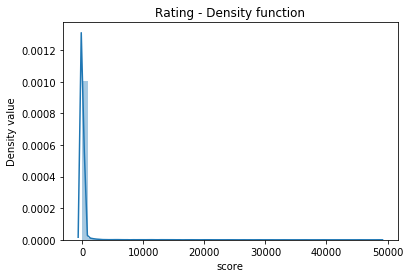

In [201]:
# plot scores with outliers.
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [202]:
mean = y_train.mean()
std = y_train.std()

X_train,y_train = remove_skew_95(X_train,y_train,mean,std)
X_test,y_test = remove_skew_95(X_test,y_test,mean,std)

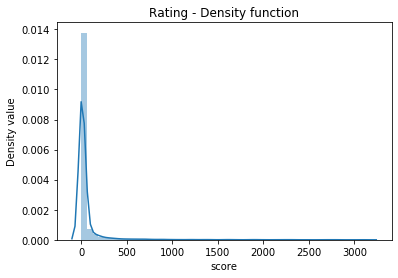

In [203]:
# plot scores without outliers.
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

## Features scaling

### Target variable - joke score

Distribution before any preprocessing

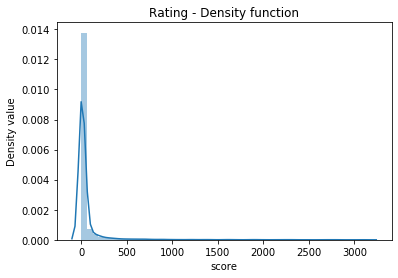

In [204]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

Use log to the target varible and scaling [0,1] -> try to create normal distribution.

In [205]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [206]:
scaler = MinMaxScaler()
scaler.fit(y_train.to_numpy().reshape(-1, 1))
y_train = pd.DataFrame(scaler.transform(y_train.to_numpy().reshape(-1, 1)))
y_test = pd.DataFrame(scaler.transform(y_test.to_numpy().reshape(-1, 1)))

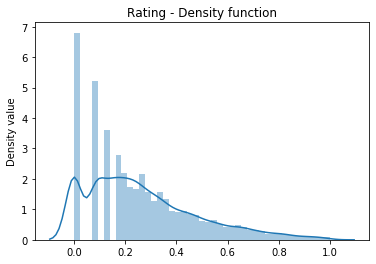

In [207]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

### Feature scaling

In [208]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.to_list())
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns.to_list())

In [209]:
# verify that there is no missing values after the preprossing.
missing_X_train = check_missing_data(X_train)
missing_X_test = check_missing_data(X_test)

assert not missing_X_train
assert not missing_X_test

## Feature selection

Run Extra Tree for extract best features (without the embedding features).

In [210]:
all_features_names = X_train.columns # .str.startswith("UNIVERSAL_SENTENCE_ENCODER")
embedding_features = [f for f in all_features_names if "UNIVERSAL_SENTENCE_ENCODER" in f]
features_without_embedding = [f for f in all_features_names if f not in embedding_features]

In [211]:
select_f_model = ExtraTreesRegressor(n_estimators=2)
select_f_model.fit(X_train[features_without_embedding], y_train)
select_features = SelectFromModel(select_f_model, prefit=True) 
selected_df = select_features.transform(X_train[features_without_embedding])
num_of_features = selected_df.shape[1]

# Sort feature importances in descending order, and remain the best features by the seletion model
importances = select_f_model.feature_importances_
indices = np.argsort(importances)[::-1][:num_of_features]

# get feature names list
importance_features_names = [X_train[features_without_embedding].columns[i] for i in indices]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [212]:
selected_X_train = X_train.loc[:,importance_features_names + embedding_features]
selected_X_test = X_test.loc[:,importance_features_names + embedding_features]

assert selected_X_train.shape[1] == selected_X_test.shape[1]

In [213]:
selected_X_train.head(1)

,MEAN_CHARACTERS_PER_WORD(joke),PUNCTUATION_COUNT(joke),total_chars,speical_chars,STOPWORD_COUNT(joke),best_score_similarity_words,POLARITY_SCORE(joke),longest_word,ambiguous_words,total_words,TITLE_WORD_COUNT(joke),UPPER_CASE_COUNT(joke),PART,ADJ,CCONJ,SCONJ,ADV,PERSON,ADP,AUX,tea,watching,SPACE,DATE,different,NUM,PRON,ORG,PROPN,close,CARDINAL,chocolate,DET,able,NORP,cross,GPE,lead,screw light,world,INTJ,politician,VERB,laugh,live,pussy,hospital,perfect,moon,terrorist,step,blew,wonder,wrong,marriage,bra,jewish,building,help,fruit,force,10,bolt,sodium,hardest,mad,boyfriend,12,officer,stop,apple,pig,science,worry,sex,looked,shoot,french,pulled,gold,cancer,finish,rock,dead,putting,cell,inside,look,human,20,getting,trying,PRODUCT,scientist,moment,looking,ORDINAL,olympics,reply,trouble,popular,fly,club,shot,stole,computer,africa,meet,rio,joke_y,happens,bear,tomorrow,90,believe,cut,NOUN,brown,patient,dealer,football,piano,antonyms,rest,mum,ride,return,winning,harry,leg,fell,prostitute,whore,post,fucked,left,walked,family,home,bartender say,clinton,edit,calling,trigger,wait,team,kitchen,change light,friend said,taste like,say man,card,train,half,american,finally,drunk,starting,terrible,leaf,party,11,test,talking,expect,wood,heart,ta,ship,fear,repost,pizza,feel,age,married,tell,hell,bar bartender,news,speech,TIME,hi,baby,female,white,sure,okay,north,chicken,beat,seeing,blue,husband,buy,grandfather,say hey,place,later,fine,band,people say,run,pick,virgin,touch,man walk,invented,dating,story,phone,bee,jesus,class,police officer,taken,pun,paper,100,britain,redditor,gas,law,reading,paid,valentine,kept,met,tank,type people,2016,donald trump,QUANTITY,magician,woke,answer,deal,play,wake,video,daddy,ended,serve,afraid,saw,pee,cake,bird,flying,died,priest,...,UNIVERSAL_SENTENCE_ENCODER(joke)[262],UNIVERSAL_SENTENCE_ENCODER(joke)[263],UNIVERSAL_SENTENCE_ENCODER(joke)[264],UNIVERSAL_SENTENCE_ENCODER(joke)[265],UNIVERSAL_SENTENCE_ENCODER(joke)[266],UNIVERSAL_SENTENCE_ENCODER(joke)[267],UNIVERSAL_SENTENCE_ENCODER(joke)[268],UNIVERSAL_SENTENCE_ENCODER(joke)[269],UNIVERSAL_SENTENCE_ENCODER(joke)[270],UNIVERSAL_SENTENCE_ENCODER(joke)[271],UNIVERSAL_SENTENCE_ENCODER(joke)[272],UNIVERSAL_SENTENCE_ENCODER(joke)[273],UNIVERSAL_SENTENCE_ENCODER(joke)[274],UNIVERSAL_SENTENCE_ENCODER(joke)[275],UNIVERSAL_SENTENCE_ENCODER(joke)[276],UNIVERSAL_SENTENCE_ENCODER(joke)[277],UNIVERSAL_SENTENCE_ENCODER(joke)[278],UNIVERSAL_SENTENCE_ENCODER(joke)[279],UNIVERSAL_SENTENCE_ENCODER(joke)[280],UNIVERSAL_SENTENCE_ENCODER(joke)[281],UNIVERSAL_SENTENCE_ENCODER(joke)[282],UNIVERSAL_SENTENCE_ENCODER(joke)[283],UNIVERSAL_SENTENCE_ENCODER(joke)[284],UNIVERSAL_SENTENCE_ENCODER(joke)[285],UNIVERSAL_SENTENCE_ENCODER(joke)[286],UNIVERSAL_SENTENCE_ENCODER(joke)[287],UNIVERSAL_SENTENCE_ENCODER(joke)[288],UNIVERSAL_SENTENCE_ENCODER(joke)[289],UNIVERSAL_SENTENCE_ENCODER(joke)[290],UNIVERSAL_SENTENCE_ENCODER(joke)[291],UNIVERSAL_SENTENCE_ENCODER(joke)[292],UNIVERSAL_SENTENCE_ENCODER(joke)[293],UNIVERSAL_SENTENCE_ENCODER(joke)[294],UNIVERSAL_SENTENCE_ENCODER(joke)[295],UNIVERSAL_SENTENCE_ENCODER(joke)[296],UNIVERSAL_SENTENCE_ENCODER(joke)[297],UNIVERSAL_SENTENCE_ENCODER(joke)[298],UNIVERSAL_SENTENCE_ENCODER(joke)[299],UNIVERSAL_SENTENCE_ENCODER(joke)[300],UNIVERSAL_SENTENCE_ENCODER(joke)[301],UNIVERSAL_SENTENCE_ENCODER(joke)[302],UNIVERSAL_SENTENCE_ENCODER(joke)[303],UNIVERSAL_SENTENCE_ENCODER(joke)[304],UNIVERSAL_SENTENCE_ENCODER(joke)[305],UNIVERSAL_SENTENCE_ENCODER(joke)[306],UNIVERSAL_SENTENCE_ENCODER(joke)[307],UNIVERSAL_SENTENCE_ENCODER(joke)[308],UNIVERSAL_SENTENCE_ENCODER(joke)[309],UNIVERSAL_SENTENCE_ENCODER(joke)[310],UNIVERSAL_SENTENCE_ENCODER(joke)[311],UNIVERSAL_SENTENCE_ENCODER(joke)[312],UNIVERSAL_SENTENCE_ENCODER(joke)[313],UNIVERSAL_SENTENCE_ENCODER(joke)[314],UNIVERSAL_SENTENCE_ENCODER(joke)[315],UNIVERSAL_SENTENCE_ENCODER(joke)[316],UNIVERSAL_SENTENCE_ENCODER(joke)[317],UNIVERSAL_SENTENCE_ENCODER(joke)[318],UNIVERSAL_SENTENCE_ENCODER(joke)[319],UNIVERSAL_SENTENCE_ENC

In [214]:
pd.to_pickle(selected_X_train, path + "Selected_X_train.pkl")
pd.to_pickle(selected_X_test, path + "Selected_X_test.pkl")
pd.to_pickle(y_train, path + "Selected_y_train.pkl")
pd.to_pickle(y_test, path + "Selected_y_test.pkl")